---

# The 2021 Russian Grand Prix
**Author: Regaska Pudawara**

Exercise study inspired from [@jaspervhat](https://medium.com/towards-formula-1-analysis/formula-1-data-analysis-tutorial-2021-russian-gp-to-box-or-not-to-box-da6399bd4a39)

---

## Introduction
Another amazing weekend in Formula 1 2021 season with another unpredictable race in Sochi. With the track drying out, Lando Norris able to snatched his maiden pole position by perfect timing in Q3. Sunday proved to be very tense for the race leader with the gap getting closer and closer as Lewis Hamilton chasing for his another win for the season. And then.. **rain** once again become the biggest factor that influenced the race.

## Analytical Task
With the rain coming at the very last stage of the race, the teams are frantically trying to came up with the best decision whether to pit for inters or stick with the slick tyres. This decision could become very significant for the result of the race as evidenced in the past where the team that made the best decision at the right time could benefit from the race by gaining position massively and eventually win the race. Here we are trying to use analytical approach using data science to help making the best decision based on the data available.

## Setting everything up
To start everything, we need to load all packages required for this analysis.

In [1]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
import numpy as np
import pandas as pd
%matplotlib inline

Next, we need to enable the plotting functionality and cache.

In [2]:
# Setup Plotting
plotting.setup_mpl()

# Enable the cache
ff1.Cache.enable_cache('C:/Users/user/PycharmProjects/formula1_python/cache')

# Get rid of some panda warnings that are not relevant for us at the moment
pd.options.mode.chained_assignment = None

## Data Collection
After that, we load the session data for this case we need the 2021 Russian GP Race data. Since we want to use telemetry data on this analysis, we set the `with_telemetry` to `True`.

In [3]:
# Load the session data
race = ff1.get_session(2021, 'Russia', 'R')

# Get the laps
laps = race.load_laps(with_telemetry=True)

core           INFO 	Loading laps for Russian Grand Prix - Race [v2.1.13]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['7', '44', '55', '14', '4', '9', '10', '16', '11', '63', '6', '77', '5', '22', '18', '33', '3', '99', '31', '47']


### Data Transformation
After loading the data there will be few modifications necessary to process the data. First, we need to create variable `RaceLapNumber` and we need to select only the laps after rain start to pour (Lap 45 onwards).

In [4]:
# Calculate RaceLapNumber (LapNumber minus 1 since the warmuplap is included in LapNumber)
laps['RaceLapNumber'] = laps['LapNumber'] - 1

# Starting from lap 45 where it started raining
laps = laps.loc[laps['RaceLapNumber'] >= 45]

To create comparison per lap, we need to find out the lap-by-lap telemetry. Since the library Fastf1 only allow to retrieve telemetry per driver, we need to perform multiple loops to get the data in the desired format

In [5]:
# Get all drivers
drivers = pd.unique(laps['Driver'])

telemetry = pd.DataFrame()

# Telemetry can only be retrieved driver-by-driver
for driver in drivers:
    driver_laps = laps.pick_driver(driver)

    # Since we want to compare distances, we need to collect telemetry lap-by-lap to reset the distance
    for lap in driver_laps.iterlaps():
        driver_telemetry = lap[1].get_telemetry().add_distance()
        driver_telemetry['Driver'] = driver
        driver_telemetry['Lap'] = lap[1]['RaceLapNumber']
        driver_telemetry['Compound'] = lap[1]['Compound']
        
        telemetry = pd.concat([telemetry, driver_telemetry])

After this, we only have to make two modifications left: select only the column that we need and group all 'Hard', 'Medium', and 'Soft' compound to 'SLICK'

In [6]:
# Only keep required columns
telemetry = telemetry[['Lap', 'Distance', 'Compound', 'Speed', 'X', 'Y']]

# Everything that's not intermediate will be slick
telemetry['Compound'].loc[telemetry['Compound'] != 'INTERMEDIATE'] = 'SLICK'

### Create mini-sectors and calculate the fastest compounds
Now we can start looking at which tyre was the fastest at which point during the lap in the track, here are the steps:
1. Create mini-sectors by split the lap into 25 equal part

In [7]:
# We want 25 mini-sectors
num_minisectors = 25

# What is the total distance of a lap?
total_distance = max(telemetry['Distance'])

# Generate equally sized mini-sectors
minisector_length = total_distance / num_minisectors

minisectors = [0]

for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

2. Assign each row in the telemetry data with the minisector it currently in

In [8]:
# Assign minisectors to every row in telemetry data
telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda z: (
        minisectors.index(
            min(minisectors, key=lambda x: abs(x-z)))+1
    )
)

3. Group the dataframe by lap, minisector, and compound and then calculate the mean speed to find out which tyre is the fastest at any point during the lap

In [9]:
# Calculate fastest tyre per minisector
average_speed = telemetry.groupby(['Lap', 'Minisector', 'Compound'])['Speed'].mean().reset_index()

The following dataframe shows the average speed for every lap, minisector, and compound

In [10]:
telemetry

,Lap,Distance,Compound,Speed,X,Y,Minisector
2,45,0.000000,SLICK,183,1304,-424,1
3,45,2.004167,SLICK,185,1273,-428,1
4,45,2.056944,SLICK,190,1272,-428,1
5,45,13.797778,SLICK,193,1206,-525,1
6,45,14.941111,SLICK,196,1199,-534,1
...,...,...,...,...,...,...,...
979,52,5796.491667,INTERMEDIATE,139,1353,-316,25
980,52,5797.862500,INTERMEDIATE,141,1347,-325,25
981,52,5805.846667,INTERMEDIATE,143,1319,-361,25
982,52,5806.007778,INTERMEDIATE,145,1318,-361,25


Using this data, we're trying to select which compound is the fastest per minisector per lap. The `idmax()` method give us the ID of the row with the highest speed per lap per minisector.

In [11]:
# Select the compound with the highest average speed
fastest_compounds = average_speed.loc[average_speed.groupby(['Lap', 'Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the Compound column
fastest_compounds = fastest_compounds[['Lap', 'Minisector', 'Compound']].rename(columns={'Compound': 'Fastest_compound'})

To finish collecting and transforming all the data, there are three more things that's need to be done:
1. Merge the telemetry data with the fastest compound per sector
2. Order the telemetry data by distance
3. Assign an integer value to tyre compound since matplotlib can only handle integer value

In [12]:
# Join the fastest compound per minisector with the full telemetry
telemetry = telemetry.merge(fastest_compounds, on=['Lap', 'Minisector'])

# Order the data by distance to make matplotlib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Assign integer values to the compound so matplotlib can understand it better
telemetry.loc[telemetry['Fastest_compound'] == "INTERMEDIATE", 'Fastest_compound_int'] = 1
telemetry.loc[telemetry['Fastest_compound'] == "SLICK", 'Fastest_compound_int'] = 2

## Data Plotting
Finally, we can start to plot the data. Since we want to generate separate plots per lap, we will put the code into a method to avoid having to repeat ourselves.

In [13]:
def generate_minisector_plot(lap, save=False, details=True):
    single_lap = telemetry.loc[telemetry['Lap'] == lap]

    x = np.array(single_lap['X'].values)
    y = np.array(single_lap['Y'].values)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    compound = single_lap['Fastest_compound_int'].to_numpy().astype(float)

    cmap = cm.get_cmap('ocean', 2)
    lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
    lc_comp.set_array(compound)
    lc_comp.set_linewidth(2)

    plt.rcParams['figure.figsize'] = [12, 5]

    if details:
        title = plt.suptitle(
            f"2021 Russian GP \n Lap {lap} - Slicks vs. Inters"
        )

    plt.gca().add_collection(lc_comp)
    plt.axis('equal')
    plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

    if details:
        cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1, 4))
        cbar.set_ticks(np.arange(1.5, 3.5))
        cbar.set_ticklabels(['Inters', 'Slicks'])

    if save:
        plt.savefig(f"C:/Users/user/PycharmProjects/formula1_python/2021_russia_gp_rain/img/minisectors_lap_{lap}.png",
                    dpi=300)

    plt.show()

This plot might be uncommon as it is not your everyday plot, this plot draws a line in the shape of the circuit. After this, we can call the method to generate a plot of the lap for us.

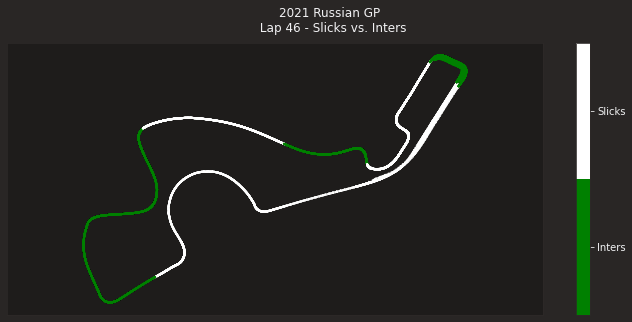

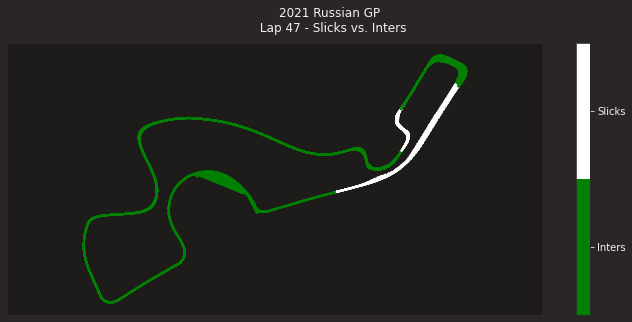

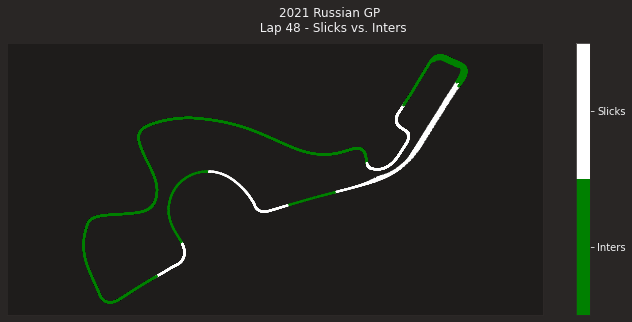

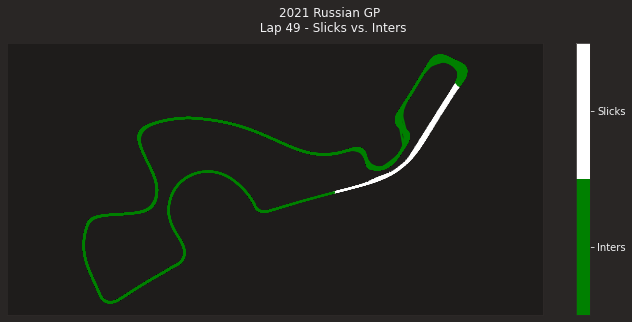

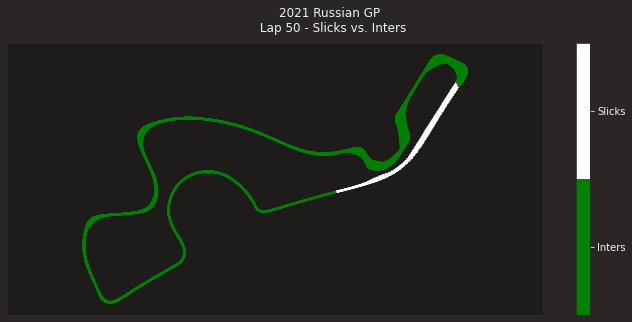

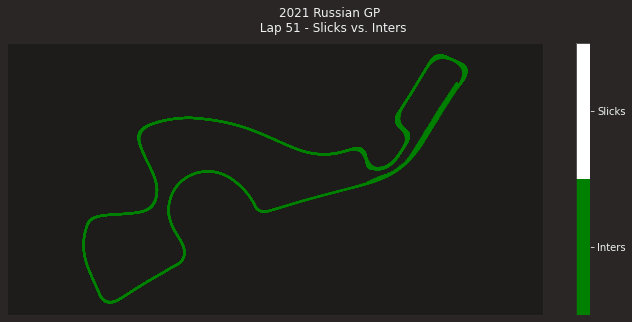

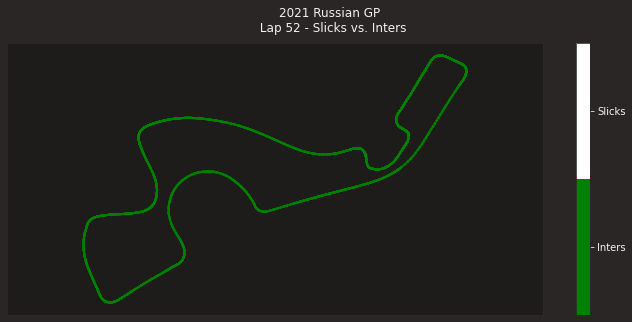

In [14]:
generate_minisector_plot(46, save=True, details=True)
generate_minisector_plot(47, save=True, details=True)
generate_minisector_plot(48, save=True, details=True)
generate_minisector_plot(49, save=True, details=True)
generate_minisector_plot(50, save=True, details=True)
generate_minisector_plot(51, save=True, details=True)
generate_minisector_plot(52, save=True, details=True)

## Conclusions
In the end, it appears in many parts of the track, the intermediate tyre is significantly faster compared to the slicks. The question remains whether it is beneficial to spend 20+ seconds to pit or doing 3-4 laps slow laps on the slicks. As proved in the race, boxing to change to inters is the correct decision as the track become undrivable in the slicks.